In [31]:
import os
import json
import pickle
import sys
sys.path.insert(0, '../')
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import *
from src.PerformanceAnalyzer import *
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.Task import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import IncrementalPCA as iPCA
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
np.set_printoptions(suppress = True)
%matplotlib inline

In [32]:
disp = True
activation = "relu"
taskname = "CDDM"

In [48]:
# RNN_folder = '0.0089902_20230318-203649'
# RNN_folder = '0.0077046_20230222-045211'
RNN_folder = "0.0172456_20230320-190726"
RNN_folder_full_path = os.path.join("../", "../", "rnn_coach", "data", "trained_RNNs", "TaskCDDM_tanh", RNN_folder)
mse_score_RNN = os.listdir(RNN_folder_full_path)[0].split("_")[0]
rnn_config = json.load(open(os.path.join(RNN_folder_full_path, f"{mse_score_RNN}_config.json"), "rb+"))
rnn_data = json.load(open(os.path.join(RNN_folder_full_path, f"{mse_score_RNN}_params_TaskCDDM_tanh.json"), "rb+"))
train_config_file = f"train_config_{taskname}_{activation}.json"

In [49]:
activation_name = rnn_config["activation"]
RNN_N = rnn_config["N"]
n_steps = rnn_config["n_steps"]
task_params = rnn_config["task_params"]
if activation_name == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation_RNN = torch.tanh
elif activation_name == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))
dt = rnn_config["dt"]
tau = rnn_config["tau"]
connectivity_density_rec = rnn_config["connectivity_density_rec"]
spectral_rad = rnn_config["sr"]
sigma_inp = rnn_config["sigma_inp"]
sigma_rec = rnn_config["sigma_rec"]
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)
input_size = np.array(rnn_data["W_inp"]).shape[1]
output_size = np.array(rnn_data["W_out"]).shape[0]

RNN = RNN_torch(N=RNN_N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation_RNN, random_generator=rng, device=device,
                      sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": np.array(rnn_data["W_inp"]),
              "W_rec": np.array(rnn_data["W_rec"]),
              "W_out": np.array(rnn_data["W_out"]),
              "b_rec": np.array(rnn_data["bias_rec"]),
              "y_init": np.zeros(RNN_N)}
RNN.set_params(RNN_params)
Task = eval("Task" + taskname)(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)


seed: 116707
Using cpu for RNN!


In [50]:
input_batch, target_batch, conditions_batch = Task.get_batch()
RNN.sigma_rec = RNN.sigma_inp = torch.tensor(0, device=RNN.device)
y, predicted_output_rnn = RNN(torch.from_numpy(input_batch.astype("float32")).to(RNN.device))
Y = np.hstack([y.detach().numpy()[:, :, i] for i in range(y.shape[-1])]).T

In [51]:
Y_mean = np.mean(np.abs(Y), axis=0)
th = np.percentile(Y_mean, 67)
inds = np.where(Y_mean > th)[0]

<IPython.core.display.Javascript object>


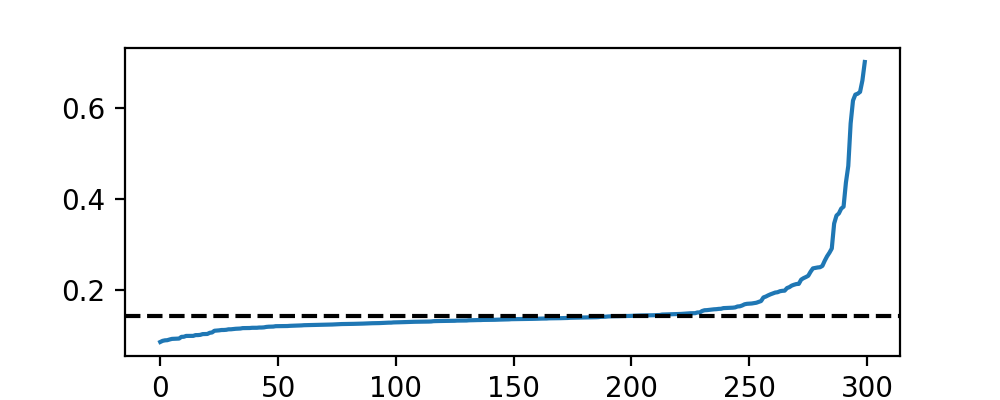

In [52]:
fig = plt.figure(figsize = (5,2))
plt.plot(np.sort(Y_mean))
plt.axhline(th, linestyle='--', color='k')
plt.show()

In [53]:
svd = TruncatedSVD(n_components=20, n_iter=11)
svd.fit(Y)

TruncatedSVD(n_components=20, n_iter=11)

In [54]:
Y_projected = svd.components_.T
Y_projected_filtered = Y_projected[inds, :]

In [55]:
svd.explained_variance_ratio_

array([0.29246315, 0.29535168, 0.2623684 , 0.07423683, 0.02816827,
       0.02018955, 0.00682607, 0.00328172, 0.00265196, 0.00239876,
       0.00205708, 0.00176131, 0.00131384, 0.00114392, 0.00096954,
       0.00085479, 0.00061085, 0.00051259, 0.00047222, 0.00037907],
      dtype=float32)

In [41]:
gm = GaussianMixture(n_components=8, max_iter=10000, n_init=201, tol=1e-13, verbose=1, init_params='k-means++')
lbls = gm.fit_predict(Y_projected_filtered)

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True
Initialization 5
Initialization converged: True
Initialization 6
Initialization converged: True
Initialization 7
  Iteration 10
Initialization converged: True
Initialization 8
Initialization converged: True
Initialization 9
Initialization converged: True
Initialization 10
Initialization converged: True
Initialization 11
Initialization converged: True
Initialization 12
  Iteration 10
Initialization converged: True
Initialization 13
Initialization converged: True
Initialization 14
  Iteration 10
Initialization converged: True
Initialization 15
Initialization converged: True
Initialization 16
  Iteration 10
Initialization converged: True
Initialization 17
Initializ

Initialization converged: True
Initialization 151
Initialization converged: True
Initialization 152
Initialization converged: True
Initialization 153
  Iteration 10
Initialization converged: True
Initialization 154
Initialization converged: True
Initialization 155
  Iteration 10
Initialization converged: True
Initialization 156
Initialization converged: True
Initialization 157
Initialization converged: True
Initialization 158
Initialization converged: True
Initialization 159
Initialization converged: True
Initialization 160
Initialization converged: True
Initialization 161
  Iteration 10
Initialization converged: True
Initialization 162
Initialization converged: True
Initialization 163
Initialization converged: True
Initialization 164
Initialization converged: True
Initialization 165
Initialization converged: True
Initialization 166
  Iteration 10
Initialization converged: True
Initialization 167
Initialization converged: True
Initialization 168
Initialization converged: True
Initializ

In [42]:
Y_projected_filtered.shape

(99, 20)

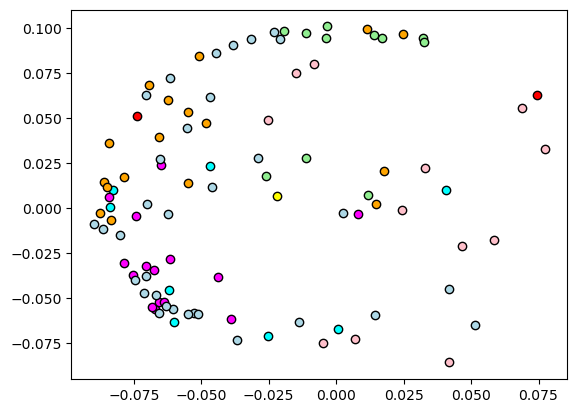

In [43]:
# %matplotlib notebook
colors = ['r', 'lightgreen', 'lightblue', 'yellow', 'orange', 'magenta', 'cyan', 'pink', 'k']

fig = plt.figure()
ax = fig.add_subplot()
for i, lbl in enumerate(lbls):
    xs = Y_projected_filtered[i, 0]
    ys = Y_projected_filtered[i, 1]
    zs = Y_projected_filtered[i, 2]
    ax.scatter(ys, zs, color=colors[lbl], edgecolor='k')
#     ax.scatter(xs, ys, zs, color='r', s=30, edgecolor='k')
plt.show()

<IPython.core.display.Javascript object>


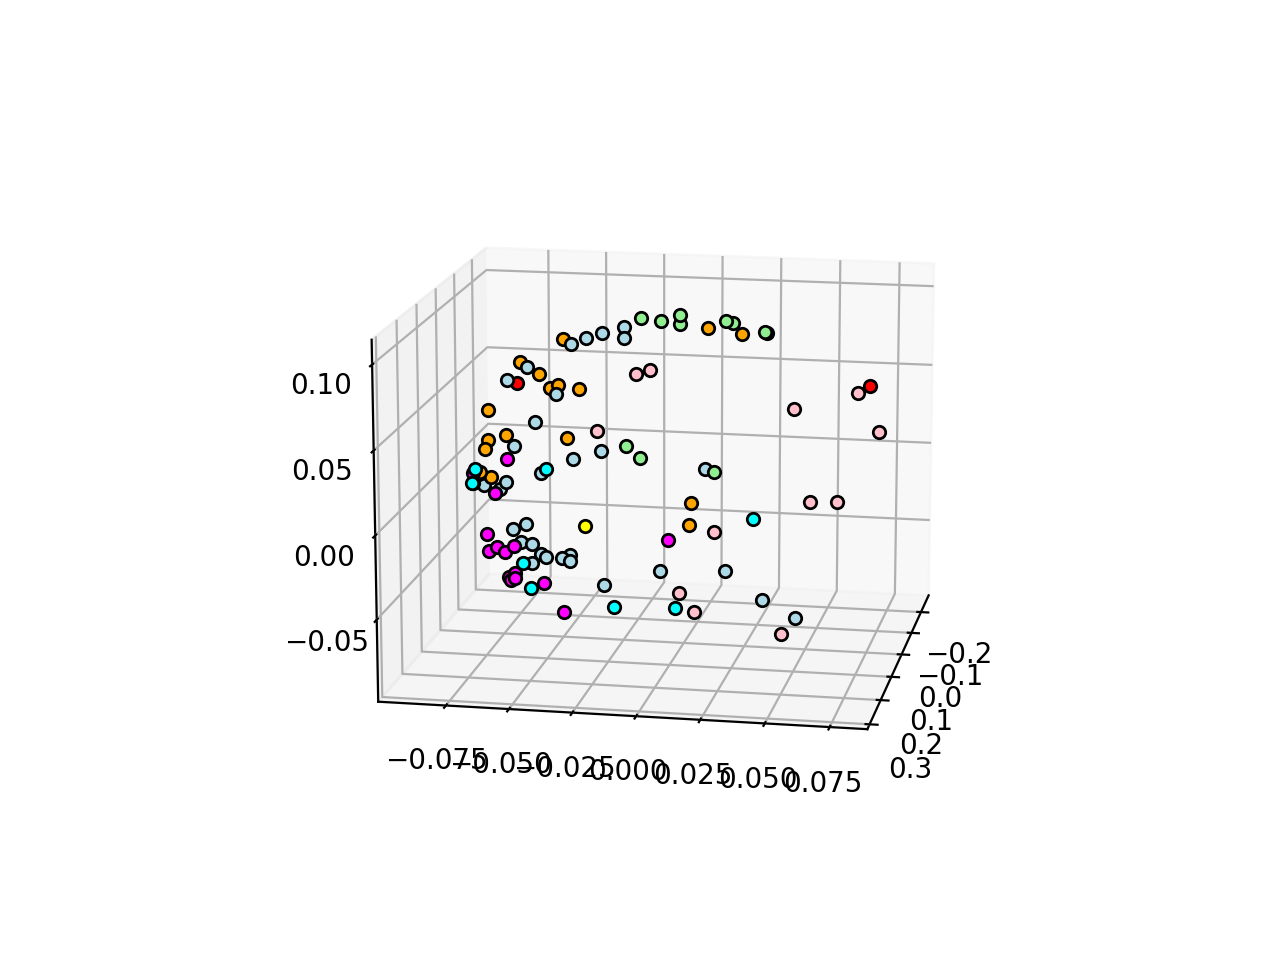

In [44]:
%matplotlib notebook
colors = ['r', 'lightgreen', 'lightblue', 'yellow', 'orange', 'magenta', 'cyan', 'pink', 'k']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, lbl in enumerate(lbls):
    xs = Y_projected_filtered[i, 0]
    ys = Y_projected_filtered[i, 1]
    zs = Y_projected_filtered[i, 2]
    ax.scatter(xs, ys, zs, color=colors[lbl], edgecolor='k')
#     ax.scatter(xs, ys, zs, color='r', s=30, edgecolor='k')
plt.show()

{'context': 'motion', 'motion_coh': 0.4, 'color_coh': -0.05, 'correct_choice': 1}


<IPython.core.display.Javascript object>


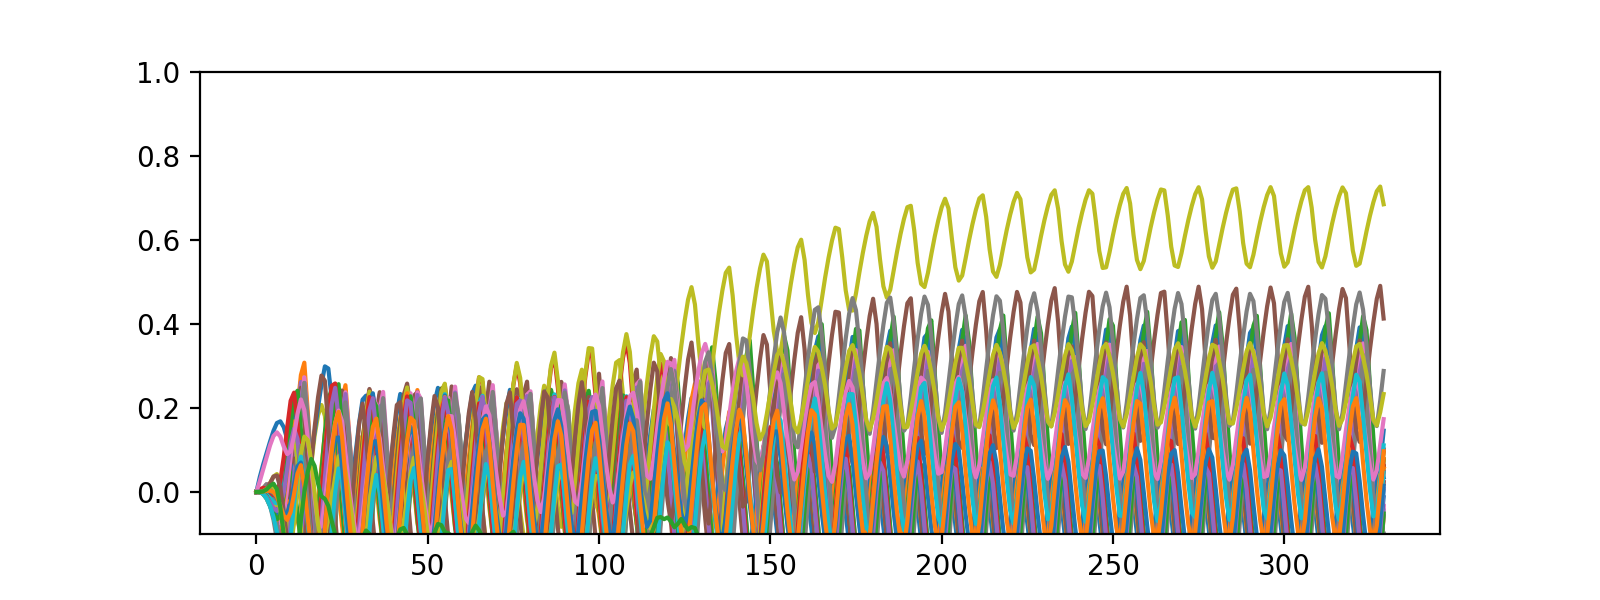

[0, 12, 45, 58, 61, 63, 66, 69, 70, 81, 87, 88, 100, 115, 121, 124, 146, 156, 174, 187, 194, 210, 222, 228, 230, 233, 269, 270, 272, 275, 289, 295, 297]


In [47]:
trial_num = 199
print(conditions_batch[trial_num])
fig = plt.figure(figsize = (8, 3))
tmp = np.where(lbls == np.int32(2))[0]
inds_lbl = [inds[i] for i in tmp]
print(inds_lbl)
for ind in inds_lbl:
    plt.plot(y[ind, :, trial_num].detach().numpy())
plt.ylim([-0.1,1])
plt.show()